## Model Training

In this file, we create an MLP model using Keras. As an example program, we are training a model which can classify a hand gesture between one and five, based on the number of fingers that are held up. We train this model using the training data we collected in 'gesture_data_collection.ipynb'. Once the model is sufficiently well trained, we test the performance of the model.

In [46]:
import mediapipe as mp
import cv2
import os
import csv
import numpy as np
import ast
import random
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.regularizers import l2
from keras.utils import np_utils
import kerastuner as kt
import matplotlib.pyplot as plt

#Use this list to add the class names for each gesture
num_classes = 6
class_names = ["one", "two", "three", "four", "five", "other"] 

In the below cell, we retrieve the training data from the csv files and prepare it so that it can be used to train the model. The training samples from all the files are extracted into a list and the list is shuffled. Each training sample(each item in the list) contains the following:
- The class label, 
- The handedness (left or right),
- 21 xyz coordinates, as string representations of lists, which represent the 21 landmarks detected on the hand. 

Firstly, the labels are separated from each training sample into a separate numpy array. One-hot-encoding is done on this array so that it matches the softmax output of the model. Next, the landmark coordinates are separated from the handedness. The landmark coordinates are converted from string representations of lists to actual python lists. That is, for each xyz coordinate we do the following conversion:

"[x, y, z]" &rarr; [x, y, z]

Next, for each training sample, we normalize the x and y coordinates. This is done so that the distance between the camera and the hand does not have a big influence on the prediction. 

We flatten the 21 xyz coordinates into a single array of lenth 63. Lastly, We concatenate the handedness variables to their respective array. As we can see after running the cell, our input array consists of 656 training samples of length 64 each.

In [48]:
data = []
for i in range(num_classes):
    reader = csv.reader(open("training_samples/training_" + str(i) + 
                             ".csv", "r"), delimiter=",")
    data += list(reader)    

random.shuffle(data)

labels = []
handedness = []
hand_samples = []

for row in data:
    labels.append(row[0])
    handedness.append(row[1])
    hand_samples.append(row[2:])

# Extraxt labels and convert them to categorical labels
labels = np.array(labels)
y = np_utils.to_categorical(labels)

handedness = np.array(handedness).astype('int')
handedness = handedness.reshape(handedness.shape[0], 1) 

# Convert string representation of list to python list for every landmark coordinate
for sample in hand_samples:
    for ix, landmark in enumerate(sample):
        sample[ix] = ast.literal_eval(landmark)
        
# Adjust coordinate values for each sample according to that sample's bounding box
hand_samples = np.array(hand_samples)
for ix, sample in enumerate(hand_samples):   
    x_max, x_min = np.max(sample[:,0]), np.min(sample[:,0])
    y_max, y_min = np.max(sample[:,1]), np.min(sample[:,1])
    x_diff = x_max - x_min
    y_diff = y_max - y_min
    hand_samples[ix][:,0] = (hand_samples[ix][:,0] - x_min)/x_diff
    hand_samples[ix][:,1] = (hand_samples[ix][:,1] - y_min)/y_diff

# Combine handedness with landmark coordinates to prepare training input
hand_samples = hand_samples.reshape(hand_samples.shape[0], 63)
x = np.concatenate((handedness, hand_samples), axis = 1)

#unique, counts = np.unique(labels, return_counts=True)
#print(np.asarray((unique, counts)).T)

print(x.shape)

(656, 64)


In the below cell, we develop an MLP model with 3 hidden layers that use RELU activation. Dropout is applied on each hidden layer to prevent overfitting. The output layer is a softmax layer with the same number of nodes as the number of classes.

This model is trained using categorical crossentropy as the loss function, and adam optimizer to adjust the model parameters. The plot_result function plots the training and validation accuracy recorded after every epoch.

In [59]:
model = Sequential()
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 750
history = model.fit(x, y, epochs = epochs, validation_split = 0.2, batch_size = None)

Epoch 1/750
17/17 [==============================] - 0s 12ms/step - loss: 1.8320 - accuracy: 0.1927 - val_loss: 1.7631 - val_accuracy: 0.2955
Epoch 2/750
17/17 [==============================] - 0s 4ms/step - loss: 1.7847 - accuracy: 0.2309 - val_loss: 1.7599 - val_accuracy: 0.2500
Epoch 3/750
17/17 [==============================] - 0s 4ms/step - loss: 1.7683 - accuracy: 0.2290 - val_loss: 1.7579 - val_accuracy: 0.2576
Epoch 4/750
17/17 [==============================] - 0s 4ms/step - loss: 1.7695 - accuracy: 0.2500 - val_loss: 1.7432 - val_accuracy: 0.2348
Epoch 5/750
17/17 [==============================] - 0s 4ms/step - loss: 1.7337 - accuracy: 0.2557 - val_loss: 1.7105 - val_accuracy: 0.2576
Epoch 6/750
17/17 [==============================] - 0s 4ms/step - loss: 1.7407 - accuracy: 0.2424 - val_loss: 1.6910 - val_accuracy: 0.3106
Epoch 7/750
17/17 [==============================] - 0s 4ms/step - loss: 1.7137 - accuracy: 0.2748 - val_loss: 1.6708 - val_accuracy: 0.3030
Epoch 8/750


Epoch 59/750
17/17 [==============================] - 0s 3ms/step - loss: 0.5003 - accuracy: 0.7786 - val_loss: 0.3747 - val_accuracy: 0.8485
Epoch 60/750
17/17 [==============================] - 0s 3ms/step - loss: 0.4898 - accuracy: 0.7958 - val_loss: 0.3864 - val_accuracy: 0.8561
Epoch 61/750
17/17 [==============================] - 0s 4ms/step - loss: 0.4706 - accuracy: 0.8168 - val_loss: 0.3522 - val_accuracy: 0.8788
Epoch 62/750
17/17 [==============================] - 0s 4ms/step - loss: 0.4666 - accuracy: 0.8340 - val_loss: 0.3830 - val_accuracy: 0.8409
Epoch 63/750
17/17 [==============================] - 0s 4ms/step - loss: 0.4452 - accuracy: 0.8302 - val_loss: 0.3370 - val_accuracy: 0.8939
Epoch 64/750
17/17 [==============================] - 0s 4ms/step - loss: 0.5274 - accuracy: 0.7939 - val_loss: 0.3417 - val_accuracy: 0.8561
Epoch 65/750
17/17 [==============================] - 0s 3ms/step - loss: 0.4430 - accuracy: 0.8263 - val_loss: 0.3930 - val_accuracy: 0.8258
Epoch 

17/17 [==============================] - 0s 3ms/step - loss: 0.1140 - accuracy: 0.9695 - val_loss: 0.1174 - val_accuracy: 0.9773
Epoch 174/750
17/17 [==============================] - 0s 3ms/step - loss: 0.1566 - accuracy: 0.9427 - val_loss: 0.1339 - val_accuracy: 0.9773
Epoch 175/750
17/17 [==============================] - 0s 4ms/step - loss: 0.1483 - accuracy: 0.9485 - val_loss: 0.1500 - val_accuracy: 0.9697
Epoch 176/750
17/17 [==============================] - 0s 4ms/step - loss: 0.1448 - accuracy: 0.9561 - val_loss: 0.1462 - val_accuracy: 0.9697
Epoch 177/750
17/17 [==============================] - 0s 3ms/step - loss: 0.1398 - accuracy: 0.9504 - val_loss: 0.1256 - val_accuracy: 0.9773
Epoch 178/750
17/17 [==============================] - 0s 3ms/step - loss: 0.1626 - accuracy: 0.9466 - val_loss: 0.1854 - val_accuracy: 0.9470
Epoch 179/750
17/17 [==============================] - 0s 3ms/step - loss: 0.2015 - accuracy: 0.9523 - val_loss: 0.1623 - val_accuracy: 0.9621
Epoch 180/750

17/17 [==============================] - 0s 4ms/step - loss: 0.0912 - accuracy: 0.9695 - val_loss: 0.2078 - val_accuracy: 0.9773
Epoch 288/750
17/17 [==============================] - 0s 3ms/step - loss: 0.0882 - accuracy: 0.9714 - val_loss: 0.3017 - val_accuracy: 0.9697
Epoch 289/750
17/17 [==============================] - 0s 3ms/step - loss: 0.0636 - accuracy: 0.9828 - val_loss: 0.2278 - val_accuracy: 0.9697
Epoch 290/750
17/17 [==============================] - 0s 3ms/step - loss: 0.0738 - accuracy: 0.9752 - val_loss: 0.2817 - val_accuracy: 0.9697
Epoch 291/750
17/17 [==============================] - 0s 3ms/step - loss: 0.0925 - accuracy: 0.9656 - val_loss: 0.2686 - val_accuracy: 0.9697
Epoch 292/750
17/17 [==============================] - 0s 3ms/step - loss: 0.0942 - accuracy: 0.9714 - val_loss: 0.2166 - val_accuracy: 0.9697
Epoch 293/750
17/17 [==============================] - 0s 4ms/step - loss: 0.1133 - accuracy: 0.9714 - val_loss: 0.3631 - val_accuracy: 0.9621
Epoch 294/750

17/17 [==============================] - 0s 4ms/step - loss: 0.0683 - accuracy: 0.9752 - val_loss: 0.1681 - val_accuracy: 0.9773
Epoch 402/750
17/17 [==============================] - 0s 5ms/step - loss: 0.1123 - accuracy: 0.9618 - val_loss: 0.2025 - val_accuracy: 0.9773
Epoch 403/750
17/17 [==============================] - 0s 4ms/step - loss: 0.0331 - accuracy: 0.9905 - val_loss: 0.1775 - val_accuracy: 0.9773
Epoch 404/750
17/17 [==============================] - 0s 3ms/step - loss: 0.0427 - accuracy: 0.9866 - val_loss: 0.1026 - val_accuracy: 0.9773
Epoch 405/750
17/17 [==============================] - 0s 3ms/step - loss: 0.0768 - accuracy: 0.9733 - val_loss: 0.2176 - val_accuracy: 0.9697
Epoch 406/750
17/17 [==============================] - 0s 3ms/step - loss: 0.0789 - accuracy: 0.9809 - val_loss: 0.1008 - val_accuracy: 0.9773
Epoch 407/750
17/17 [==============================] - 0s 3ms/step - loss: 0.0631 - accuracy: 0.9828 - val_loss: 0.1046 - val_accuracy: 0.9697
Epoch 408/750

17/17 [==============================] - 0s 3ms/step - loss: 0.0652 - accuracy: 0.9771 - val_loss: 0.3109 - val_accuracy: 0.9697
Epoch 516/750
17/17 [==============================] - 0s 3ms/step - loss: 0.0695 - accuracy: 0.9714 - val_loss: 0.2792 - val_accuracy: 0.9848
Epoch 517/750
17/17 [==============================] - 0s 3ms/step - loss: 0.0925 - accuracy: 0.9733 - val_loss: 0.3335 - val_accuracy: 0.9773
Epoch 518/750
17/17 [==============================] - 0s 3ms/step - loss: 0.0441 - accuracy: 0.9885 - val_loss: 0.3006 - val_accuracy: 0.9848
Epoch 519/750
17/17 [==============================] - 0s 4ms/step - loss: 0.0726 - accuracy: 0.9847 - val_loss: 0.2482 - val_accuracy: 0.9848
Epoch 520/750
17/17 [==============================] - 0s 3ms/step - loss: 0.0722 - accuracy: 0.9714 - val_loss: 0.3340 - val_accuracy: 0.9773
Epoch 521/750
17/17 [==============================] - 0s 3ms/step - loss: 0.0499 - accuracy: 0.9828 - val_loss: 0.1856 - val_accuracy: 0.9848
Epoch 522/750

17/17 [==============================] - 0s 3ms/step - loss: 0.0807 - accuracy: 0.9695 - val_loss: 0.1308 - val_accuracy: 0.9848
Epoch 630/750
17/17 [==============================] - 0s 4ms/step - loss: 0.0692 - accuracy: 0.9771 - val_loss: 0.1727 - val_accuracy: 0.9773
Epoch 631/750
17/17 [==============================] - 0s 3ms/step - loss: 0.0593 - accuracy: 0.9752 - val_loss: 0.1390 - val_accuracy: 0.9924
Epoch 632/750
17/17 [==============================] - 0s 3ms/step - loss: 0.0864 - accuracy: 0.9828 - val_loss: 0.1797 - val_accuracy: 0.9773
Epoch 633/750
17/17 [==============================] - 0s 4ms/step - loss: 0.1074 - accuracy: 0.9714 - val_loss: 0.2608 - val_accuracy: 0.9697
Epoch 634/750
17/17 [==============================] - 0s 4ms/step - loss: 0.1143 - accuracy: 0.9637 - val_loss: 0.1426 - val_accuracy: 0.9848
Epoch 635/750
17/17 [==============================] - 0s 4ms/step - loss: 0.1014 - accuracy: 0.9637 - val_loss: 0.2521 - val_accuracy: 0.9545
Epoch 636/750

17/17 [==============================] - 0s 3ms/step - loss: 0.0632 - accuracy: 0.9866 - val_loss: 0.2549 - val_accuracy: 0.9545
Epoch 744/750
17/17 [==============================] - 0s 3ms/step - loss: 0.0888 - accuracy: 0.9656 - val_loss: 0.2262 - val_accuracy: 0.9697
Epoch 745/750
17/17 [==============================] - 0s 4ms/step - loss: 0.0967 - accuracy: 0.9676 - val_loss: 0.3849 - val_accuracy: 0.9773
Epoch 746/750
17/17 [==============================] - 0s 3ms/step - loss: 0.0786 - accuracy: 0.9695 - val_loss: 0.1469 - val_accuracy: 0.9848
Epoch 747/750
17/17 [==============================] - 0s 3ms/step - loss: 0.0527 - accuracy: 0.9771 - val_loss: 0.2434 - val_accuracy: 0.9773
Epoch 748/750
17/17 [==============================] - 0s 3ms/step - loss: 0.0687 - accuracy: 0.9828 - val_loss: 0.2340 - val_accuracy: 0.9697
Epoch 749/750
17/17 [==============================] - 0s 4ms/step - loss: 0.0745 - accuracy: 0.9809 - val_loss: 0.2556 - val_accuracy: 0.9773
Epoch 750/750

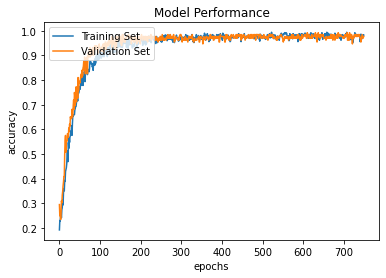

In [60]:
def plot_result(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Performance')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend(['Training Set', 'Validation Set'], loc = 'upper left')
    plt.show
    
plot_result(history)
model.save('my_model.h5')

As we can see from the training results above, the model achieves a training set accuracy of 0.9828 and validation set accuracy of 0.9773. This means that the model should have satisfactory performance. We save the model in the project directory as 'my_model.h5'.

The cell below helps us test the performance of our model. 

In [56]:
def calc_landmark_list(handedness, landmarks):
    landmark_point_list = []

    for landmark in landmarks:
        landmark_x = landmark.x
        landmark_y = landmark.y
        landmark_z = landmark.z
        landmark_point_list.append([landmark_x, landmark_y, landmark_z])
    
    landmark_point_list = np.array(landmark_point_list)
    max_val = landmark_point_list.max(axis = 0)
    min_val = landmark_point_list.min(axis = 0)
    x_max, x_min, y_max, y_min = max_val[0], min_val[0], max_val[1], min_val[1]
    x_diff = x_max - x_min
    y_diff = y_max - y_min
    landmark_point_list[:,0] = (landmark_point_list[:,0] - x_min)/x_diff
    landmark_point_list[:,1] = (landmark_point_list[:,1] - y_min)/y_diff
    landmark_point_list = landmark_point_list.reshape(63,)
    landmark_list = np.insert(landmark_point_list, 0, handedness)    
    return landmark_list

model = keras.models.load_model('my_model.h5')
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands = 1, min_detection_confidence = 0.7, min_tracking_confidence = 0.6)

cam = cv2.VideoCapture(0)
input_landmarks_list = np.array([])
ex_count = 4
while True:
    valid, img = cam.read()
    if not valid:
        print("Failed to grab frame, closing..")
        break
    height, width, channels = img.shape
    img = cv2.cvtColor(cv2.flip(img, 1), cv2.COLOR_BGR2RGB)
    img.flags.writeable = False # To improve performance, optionally mark the image as not writeable to pass by reference.
    results = hands.process(img)
    img.flags.writeable = True
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # Draw the hand annotations on the image.
    if(results.multi_hand_landmarks):
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(img, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            handedness = results.multi_handedness[0].classification[0].index
            input_landmark_list = calc_landmark_list(handedness, hand_landmarks.landmark)
            result = model.predict(x = np.array([input_landmark_list]))
            
            if np.argmax(result) < 5:
                cv2.putText(img, class_names[np.argmax(result)], (int(width * 0.4), int(height * 0.15)), 
                            cv2.FONT_HERSHEY_SIMPLEX, 2, color = (0, 0, 255), thickness = 5)
            
        cv2.imshow("Landmark Hands", img)

    k = cv2.waitKey(1)
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    '''
    if k%256 == 99:
        ex_count += 1
        print(ex_count)
        cv2.imwrite('example_img/other/img_'+str(ex_count)+'.jpg', img)
        print('img saved')
    
    if k%256 == 32:
        if(results.multi_hand_landmarks):
            for hand_landmarks in results.multi_hand_landmarks:
                input_landmark_list = get_input_landmarks(hand_landmarks.landmark)
                result = model.predict(x = np.array([input_landmark_list]))
                print(str(class_names[np.argmax(result)]) + ' ' + str(result*100))
    '''            
hands.close()
cam.release()
cv2.destroyAllWindows()

Escape hit, closing...
